


#### In this code we want to implement the bollinger band + rsi + candlestick strategy

### buy when :
1. if rsi < oversell level 
2. if price < lower band 
3. then if we had a candle whose close price was higher than the open price and higher than the lower band

### sell when :
1. if rsi > overbuy level 
2. if price > higher band 
3. then if we had a candle whose close price was lower than the open price and lower than the higher band

### SL when :

previous n candles swing (high swing for short positions / low swing for longpositions)

### TP when :
* Mehtode 1  : based on risk to rivard
* Methode 2  : middle line of bollinger band

#### First we add the required libraries
* Handling pandas warning

In [2]:
# Importing Libraries
import pandas as pd
import ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Handling Warnings
pd.options.mode.chained_assignment = None

#### Adjust the value of input parameters

In [3]:
# Settings
n_sl = 6
ror = 2
tp_method = "mbb"  # 'mbb' or 'ror'

#### Importing  EURUSD  15 min data from csv file
* if all columns of one row  was nan We will clear this row
* set value error if close was not in columns 
* set time column as a index of the data frame and rename index name to Date

In [4]:
# Read CSV file into DataFrame df
df = pd.read_csv('rsi_bb_candlestick_stra\data\EURUSD_Data.csv' ,index_col = 'time'  , parse_dates=True )
df.index.name = 'Date'
# Making Main Error
if 'close' not in df.columns :
    ValueError("We Have Necessary Need For Close Price")

# Data Quality Test
  
df.dropna(thresh=4)

# Show dataframe
df.head()

open     high      low    close
Date                                                   
2021-05-07 18:45:00  1.21606  1.21655  1.21597  1.21654
2021-05-07 19:00:00  1.21654  1.21658  1.21634  1.21650
2021-05-07 19:15:00  1.21650  1.21678  1.21638  1.21672
2021-05-07 19:30:00  1.21672  1.21703  1.21644  1.21692
2021-05-07 19:45:00  1.21692  1.21716  1.21673  1.21678

#### Making rsi and bollinger band and stop loss required columns in smry_df

In [5]:
# Creating Summary DF
smry_df = df[['open','close' , 'high' , 'low']]

# Calculate rsi column with Period 13
smry_df['rsi'] = ta.momentum.RSIIndicator(smry_df['close'],window=13).rsi()

# Calculate BollingerBands Indicator With Period 30 And StDev 2
bb_handler = ta.volatility.BollingerBands(close=smry_df['close'] , window=30 , window_dev=2)
smry_df['h_band'] = bb_handler.bollinger_hband()
smry_df['m_band'] = bb_handler.bollinger_mavg()
smry_df['l_band'] = bb_handler.bollinger_lband()

# Making Stop Loss Data
smry_df['n_high_swing'] = df['high'].rolling(n_sl).max()
smry_df['n_low_swing'] = df['low'].rolling(n_sl).min()

smry_df

open    close      high      low        rsi    h_band  \
Date                                                                            
2021-05-07 18:45:00  1.21606  1.21654  1.216550  1.21597        NaN       NaN   
2021-05-07 19:00:00  1.21654  1.21650  1.216580  1.21634        NaN       NaN   
2021-05-07 19:15:00  1.21650  1.21672  1.216780  1.21638        NaN       NaN   
2021-05-07 19:30:00  1.21672  1.21692  1.217030  1.21644        NaN       NaN   
2021-05-07 19:45:00  1.21692  1.21678  1.217160  1.21673        NaN       NaN   
...                      ...      ...       ...      ...        ...       ...   
2022-02-18 05:30:00  1.13614  1.13659  1.136610  1.13612  51.490331  1.137173   
2022-02-18 05:45:00  1.13659  1.13660  1.136745  1.13658  51.696942  1.137178   
2022-02-18 06:00:00  1.13660  1.13678  1.136880  1.13657  55.401066  1.137196   
2022-02-18 06:15:00  1.13678  1.13678  1.136960  1.13666  55.401066  1.137208   
2022-02-18 06:30:00  1.13678  1.13694  1.136940  1.13667  58.704638  1.137211   

                       m_band    l_band  n_high_swing  n_low_swing  
Date                                                                
2021-05-07 18:45:00       NaN       NaN           NaN          NaN  
2021-05-07 19:00:00       NaN       NaN           NaN          NaN  
2021-05-07 19:15:00       NaN       NaN           NaN          NaN  
2021-05-07 19:30:00       NaN       NaN           NaN          NaN  
2021-05-07 19:45:00       NaN       NaN           NaN          NaN  
...                       ...       ...           ...          ...  
2022-02-18 05:30:00  1.136494  1.135815       1.13685      1.13612  
2022-02-18 05:45:00  1.136507  1.135836       1.13684      1.13612  
2022-02-18 06:00:00  1.136525  1.135853       1.13688      1.13612  
2022-02-18 06:15:00  1.136546  1.135883       1.13696      1.13612  
2022-02-18 06:30:00  1.136546  1.135882       1.13696      1.13612  

[19615 rows x 10 columns]

#### Opening Long Position 
* when rsi and bb condition passed we set flag_long = 1
* if we have bullish  candle that its low price was lower of lower band and its close price was higher of lower band  we open long position   we open long position
* we have 2 way of sl and we have stop loss column

In [6]:
# Long Position Signals

oversell = 25
smry_df['flag_long'] = np.nan
smry_df['signal_long'] = np.nan
smry_df['long_sl_dis'] = np.nan



# Buy Conditions When RSI < 25 And Price Toch Lower Band
smry_df.loc[(smry_df['rsi'] < oversell ) & (smry_df['close'] < smry_df['l_band'] ),'flag_long'] = 1
smry_df.loc[(smry_df['flag_long'].fillna(method='ffill') == 1 ) & (smry_df['close'] > smry_df['open']) & (smry_df['low'] < smry_df['l_band']) & (smry_df['close'] > smry_df['l_band'])  ,'signal_long'] = 1
smry_df.loc[(smry_df['signal_long'] == 1 ) ,'long_sl_dis'] = smry_df['close'] - smry_df['n_low_swing']
smry_df.loc[(smry_df['signal_long'] == 1 ),'long_price'] = smry_df['close']


# Closing True Buy Position With Middle BB LINE
if tp_method == 'mbb' :
    smry_df.loc[ (smry_df['high'] >= smry_df['m_band'] ),'signal_long'] = 0
# Closing True Buy Position With ROR
elif tp_method == 'ror' :
    smry_df.loc[ ( (smry_df['close'] - smry_df['long_price'].fillna(method='ffill')) >= (smry_df['long_sl_dis'].fillna(method='ffill') * ror) ),'signal_long'] = 0
else:
    print('Your Methode Is Wrong')

# Closing False Buy Position With Previous N Candles Swing Stop Loss
smry_df.loc[(smry_df['close'] < smry_df['n_low_swing'] ) ,'signal_long'] = 0

smry_df



open    close      high      low        rsi    h_band  \
Date                                                                            
2021-05-07 18:45:00  1.21606  1.21654  1.216550  1.21597        NaN       NaN   
2021-05-07 19:00:00  1.21654  1.21650  1.216580  1.21634        NaN       NaN   
2021-05-07 19:15:00  1.21650  1.21672  1.216780  1.21638        NaN       NaN   
2021-05-07 19:30:00  1.21672  1.21692  1.217030  1.21644        NaN       NaN   
2021-05-07 19:45:00  1.21692  1.21678  1.217160  1.21673        NaN       NaN   
...                      ...      ...       ...      ...        ...       ...   
2022-02-18 05:30:00  1.13614  1.13659  1.136610  1.13612  51.490331  1.137173   
2022-02-18 05:45:00  1.13659  1.13660  1.136745  1.13658  51.696942  1.137178   
2022-02-18 06:00:00  1.13660  1.13678  1.136880  1.13657  55.401066  1.137196   
2022-02-18 06:15:00  1.13678  1.13678  1.136960  1.13666  55.401066  1.137208   
2022-02-18 06:30:00  1.13678  1.13694  1.136940  1.13667  58.704638  1.137211   

                       m_band    l_band  n_high_swing  n_low_swing  flag_long  \
Date                                                                            
2021-05-07 18:45:00       NaN       NaN           NaN          NaN        NaN   
2021-05-07 19:00:00       NaN       NaN           NaN          NaN        NaN   
2021-05-07 19:15:00       NaN       NaN           NaN          NaN        NaN   
2021-05-07 19:30:00       NaN       NaN           NaN          NaN        NaN   
2021-05-07 19:45:00       NaN       NaN           NaN          NaN        NaN   
...                       ...       ...           ...          ...        ...   
2022-02-18 05:30:00  1.136494  1.135815       1.13685      1.13612        NaN   
2022-02-18 05:45:00  1.136507  1.135836       1.13684      1.13612        NaN   
2022-02-18 06:00:00  1.136525  1.135853       1.13688      1.13612        NaN   
2022-02-18 06:15:00  1.136546  1.135883       1.13696      1.13612        NaN   
2022-02-18 06:30:00  1.136546  1.135882       1.13696      1.13612        NaN   

                     signal_long  long_sl_dis  long_price  
Date                                                       
2021-05-07 18:45:00          NaN          NaN         NaN  
2021-05-07 19:00:00          NaN          NaN         NaN  
2021-05-07 19:15:00          NaN          NaN         NaN  
2021-05-07 19:30:00          NaN          NaN         NaN  
2021-05-07 19:45:00          NaN          NaN         NaN  
...                          ...          ...         ...  
2022-02-18 05:30:00          0.0          NaN         NaN  
2022-02-18 05:45:00          0.0          NaN         NaN  
2022-02-18 06:00:00          0.0          NaN         NaN  
2022-02-18 06:15:00          0.0          NaN         NaN  
2022-02-18 06:30:00          0.0          NaN         NaN  

[19615 rows x 14 columns]

#### Opening Short Position 
* when rsi and bb condition passed we set flag_short = -1
* if we have bearish candle that its high price was higher of higher band and its close price was lower of higher band we open short position 
* we have 2 way of sl and we have stop loss column

In [7]:
# Short Position Signals

overbuy = 75
smry_df['flag_short'] = np.nan
smry_df['signal_short'] = np.nan
smry_df['short_sl_dis'] = np.nan


# Sell Conditions When RSI > 75 And Price Toch Higher Band
smry_df.loc[(smry_df['rsi'] > overbuy ) & (smry_df['close'] > smry_df['h_band'] ),'flag_short'] = -1
smry_df.loc[(smry_df['flag_short'].fillna(method='ffill') == -1 ) & (smry_df['close'] < smry_df['open']) & (smry_df['high'] > smry_df['h_band']) & (smry_df['close'] < smry_df['h_band'])  ,'signal_short'] = -1
smry_df.loc[(smry_df['signal_short'] == -1 ) ,'short_sl_dis'] =  smry_df['n_high_swing'] - smry_df['close']
smry_df.loc[(smry_df['signal_short'] == -1 ),'short_price'] = smry_df['close']

# Closing True Sell Position With Middle BB LINE
if tp_method == 'mbb' :
    smry_df.loc[ (smry_df['low'] <= smry_df['m_band'] ),'signal_short'] = 0
# Closing True Sell Position With ROR
elif tp_method == 'ror' :
    smry_df.loc[ ( ( smry_df['short_price'].fillna(method='ffill') - smry_df['close'] ) >= (smry_df['short_sl_dis'].fillna(method='ffill') * ror) ),'signal_short'] = 0
else:
    print('Your Methode Is Wrong')

# Closing False Sell Position With Previous N Candles Swing Stop Loss
smry_df.loc[(smry_df['close'] > smry_df['n_high_swing'] ) ,'signal_short'] = 0

smry_df

open    close      high      low        rsi    h_band  \
Date                                                                            
2021-05-07 18:45:00  1.21606  1.21654  1.216550  1.21597        NaN       NaN   
2021-05-07 19:00:00  1.21654  1.21650  1.216580  1.21634        NaN       NaN   
2021-05-07 19:15:00  1.21650  1.21672  1.216780  1.21638        NaN       NaN   
2021-05-07 19:30:00  1.21672  1.21692  1.217030  1.21644        NaN       NaN   
2021-05-07 19:45:00  1.21692  1.21678  1.217160  1.21673        NaN       NaN   
...                      ...      ...       ...      ...        ...       ...   
2022-02-18 05:30:00  1.13614  1.13659  1.136610  1.13612  51.490331  1.137173   
2022-02-18 05:45:00  1.13659  1.13660  1.136745  1.13658  51.696942  1.137178   
2022-02-18 06:00:00  1.13660  1.13678  1.136880  1.13657  55.401066  1.137196   
2022-02-18 06:15:00  1.13678  1.13678  1.136960  1.13666  55.401066  1.137208   
2022-02-18 06:30:00  1.13678  1.13694  1.136940  1.13667  58.704638  1.137211   

                       m_band    l_band  n_high_swing  n_low_swing  flag_long  \
Date                                                                            
2021-05-07 18:45:00       NaN       NaN           NaN          NaN        NaN   
2021-05-07 19:00:00       NaN       NaN           NaN          NaN        NaN   
2021-05-07 19:15:00       NaN       NaN           NaN          NaN        NaN   
2021-05-07 19:30:00       NaN       NaN           NaN          NaN        NaN   
2021-05-07 19:45:00       NaN       NaN           NaN          NaN        NaN   
...                       ...       ...           ...          ...        ...   
2022-02-18 05:30:00  1.136494  1.135815       1.13685      1.13612        NaN   
2022-02-18 05:45:00  1.136507  1.135836       1.13684      1.13612        NaN   
2022-02-18 06:00:00  1.136525  1.135853       1.13688      1.13612        NaN   
2022-02-18 06:15:00  1.136546  1.135883       1.13696      1.13612        NaN   
2022-02-18 06:30:00  1.136546  1.135882       1.13696      1.13612        NaN   

                     signal_long  long_sl_dis  long_price  flag_short  \
Date                                                                    
2021-05-07 18:45:00          NaN          NaN         NaN         NaN   
2021-05-07 19:00:00          NaN          NaN         NaN         NaN   
2021-05-07 19:15:00          NaN          NaN         NaN         NaN   
2021-05-07 19:30:00          NaN          NaN         NaN         NaN   
2021-05-07 19:45:00          NaN          NaN         NaN         NaN   
...                          ...          ...         ...         ...   
2022-02-18 05:30:00          0.0          NaN         NaN         NaN   
2022-02-18 05:45:00          0.0          NaN         NaN         NaN   
2022-02-18 06:00:00          0.0          NaN         NaN         NaN   
2022-02-18 06:15:00          0.0          NaN         NaN         NaN   
2022-02-18 06:30:00          0.0          NaN         NaN         NaN   

                     signal_short  short_sl_dis  short_price  
Date                                                          
2021-05-07 18:45:00           NaN           NaN          NaN  
2021-05-07 19:00:00           NaN           NaN          NaN  
2021-05-07 19:15:00           NaN           NaN          NaN  
2021-05-07 19:30:00           NaN           NaN          NaN  
2021-05-07 19:45:00           NaN           NaN          NaN  
...                           ...           ...          ...  
2022-02-18 05:30:00           0.0           NaN          NaN  
2022-02-18 05:45:00           NaN           NaN          NaN  
2022-02-18 06:00:00           NaN           NaN          NaN  
2022-02-18 06:15:00           NaN           NaN          NaN  
2022-02-18 06:30:00           NaN           NaN          NaN  

[19615 rows x 18 columns]

#### combining long and short positions

In [8]:
# Set Position 
smry_df['position'] = ( smry_df['signal_short'].fillna(method='ffill') + smry_df['signal_long'].fillna(method='ffill') )
smry_df


open    close      high      low        rsi    h_band  \
Date                                                                            
2021-05-07 18:45:00  1.21606  1.21654  1.216550  1.21597        NaN       NaN   
2021-05-07 19:00:00  1.21654  1.21650  1.216580  1.21634        NaN       NaN   
2021-05-07 19:15:00  1.21650  1.21672  1.216780  1.21638        NaN       NaN   
2021-05-07 19:30:00  1.21672  1.21692  1.217030  1.21644        NaN       NaN   
2021-05-07 19:45:00  1.21692  1.21678  1.217160  1.21673        NaN       NaN   
...                      ...      ...       ...      ...        ...       ...   
2022-02-18 05:30:00  1.13614  1.13659  1.136610  1.13612  51.490331  1.137173   
2022-02-18 05:45:00  1.13659  1.13660  1.136745  1.13658  51.696942  1.137178   
2022-02-18 06:00:00  1.13660  1.13678  1.136880  1.13657  55.401066  1.137196   
2022-02-18 06:15:00  1.13678  1.13678  1.136960  1.13666  55.401066  1.137208   
2022-02-18 06:30:00  1.13678  1.13694  1.136940  1.13667  58.704638  1.137211   

                       m_band    l_band  n_high_swing  n_low_swing  flag_long  \
Date                                                                            
2021-05-07 18:45:00       NaN       NaN           NaN          NaN        NaN   
2021-05-07 19:00:00       NaN       NaN           NaN          NaN        NaN   
2021-05-07 19:15:00       NaN       NaN           NaN          NaN        NaN   
2021-05-07 19:30:00       NaN       NaN           NaN          NaN        NaN   
2021-05-07 19:45:00       NaN       NaN           NaN          NaN        NaN   
...                       ...       ...           ...          ...        ...   
2022-02-18 05:30:00  1.136494  1.135815       1.13685      1.13612        NaN   
2022-02-18 05:45:00  1.136507  1.135836       1.13684      1.13612        NaN   
2022-02-18 06:00:00  1.136525  1.135853       1.13688      1.13612        NaN   
2022-02-18 06:15:00  1.136546  1.135883       1.13696      1.13612        NaN   
2022-02-18 06:30:00  1.136546  1.135882       1.13696      1.13612        NaN   

                     signal_long  long_sl_dis  long_price  flag_short  \
Date                                                                    
2021-05-07 18:45:00          NaN          NaN         NaN         NaN   
2021-05-07 19:00:00          NaN          NaN         NaN         NaN   
2021-05-07 19:15:00          NaN          NaN         NaN         NaN   
2021-05-07 19:30:00          NaN          NaN         NaN         NaN   
2021-05-07 19:45:00          NaN          NaN         NaN         NaN   
...                          ...          ...         ...         ...   
2022-02-18 05:30:00          0.0          NaN         NaN         NaN   
2022-02-18 05:45:00          0.0          NaN         NaN         NaN   
2022-02-18 06:00:00          0.0          NaN         NaN         NaN   
2022-02-18 06:15:00          0.0          NaN         NaN         NaN   
2022-02-18 06:30:00          0.0          NaN         NaN         NaN   

                     signal_short  short_sl_dis  short_price  position  
Date                                                                    
2021-05-07 18:45:00           NaN           NaN          NaN       NaN  
2021-05-07 19:00:00           NaN           NaN          NaN       NaN  
2021-05-07 19:15:00           NaN           NaN          NaN       NaN  
2021-05-07 19:30:00           NaN           NaN          NaN       NaN  
2021-05-07 19:45:00           NaN           NaN          NaN       NaN  
...                           ...           ...          ...       ...  
2022-02-18 05:30:00           0.0           NaN          NaN       0.0  
2022-02-18 05:45:00           NaN           NaN          NaN       0.0  
2022-02-18 06:00:00           NaN           NaN          NaN       0.0  
2022-02-18 06:15:00           NaN           NaN          NaN       0.0  
2022-02-18 06:30:00           NaN           NaN          NaN       0.0  

[19615 rows x 19

#### showing example of long position
* we used mpfinance for ploting
* we used position indicator that in buy position is 1 and in sell position is -1


c:\Users\Jafari\AppData\Local\Programs\Python\Python39\lib\site-packages\mplfinance\plotting.py:552: RuntimeWarning: All-NaN slice encountered
  miny = np.nanmin(_lows)
c:\Users\Jafari\AppData\Local\Programs\Python\Python39\lib\site-packages\mplfinance\plotting.py:553: RuntimeWarning: All-NaN slice encountered
  maxy = np.nanmax(_highs)
c:\Users\Jafari\AppData\Local\Programs\Python\Python39\lib\site-packages\mplfinance\plotting.py:552: RuntimeWarning: All-NaN slice encountered
  miny = np.nanmin(_lows)
c:\Users\Jafari\AppData\Local\Programs\Python\Python39\lib\site-packages\mplfinance\plotting.py:553: RuntimeWarning: All-NaN slice encountered
  maxy = np.nanmax(_highs)


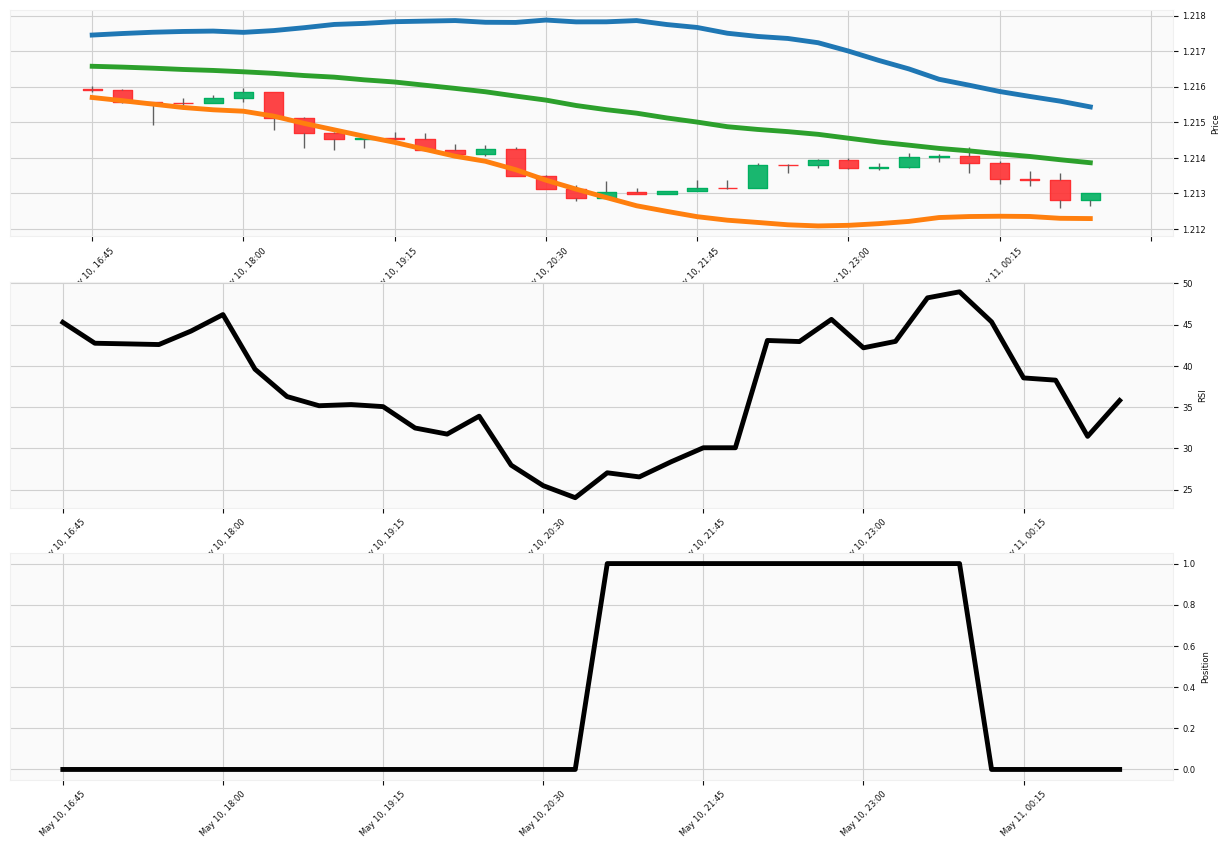

In [9]:
# Making sample signal data frame
new_df = smry_df['5/10/21 16:45' : '5/11/21 01:00' ]

# Ploting Signals

# 1) Making Empty DataFrame
empty = pd.DataFrame()
empty['Date'] = new_df.index
empty['open'] = np.nan
empty['high'] = np.nan
empty['low'] = np.nan
empty['close'] = np.nan
empty.index = new_df.index

# 2) Defining Styles And Fig
s = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'font.size': 6})
fig = mpf.figure(figsize=(15, 10), style = s )

# 3) SubPlot 1 CandleStick Price And BB
ax = fig.add_subplot(3,1,1) 
tcdf = new_df[['h_band','l_band','m_band']]
apd = mpf.make_addplot(tcdf , ax = ax)
mpf.plot(new_df, type='candle' , ax = ax  ,ylabel='Price' ,  addplot=apd)


# 4) SubPlot 2 Rsi
ax2 = fig.add_subplot(3,1,2)
rsi_p = new_df[['rsi']]
rsi_adp = mpf.make_addplot(rsi_p , ax=ax2 , color = 'black')
mpf.plot( empty , type='line', ax=ax2 , addplot=rsi_adp ,ylabel='RSI')

# 5) SubPlot 3 Position
ax2 = fig.add_subplot(3,1,3)
rsi_p = new_df[['position']]
rsi_adp = mpf.make_addplot(rsi_p , ax=ax2 , color = 'black')
mpf.plot( empty , type='line', ax=ax2 , addplot=rsi_adp ,ylabel='Position')

#### And in this part we calulate return percent of the strategy

Text(0.5, 1.0, 'Return of Strategy')

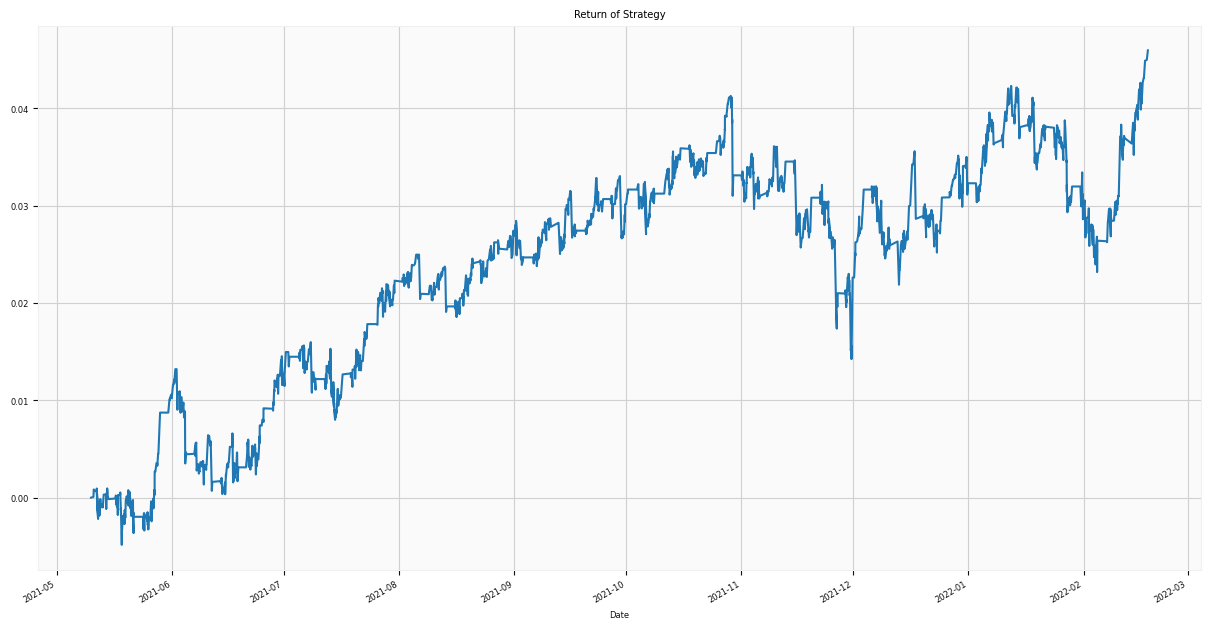

In [10]:
# profit of position

smry_df['pct'] = smry_df['close'].pct_change(1)
smry_df['return'] = smry_df['pct'] * (smry_df['position'].shift(1))
smry_df['return'].cumsum().plot(figsize=(15,8))
plt.title("Return of Strategy")


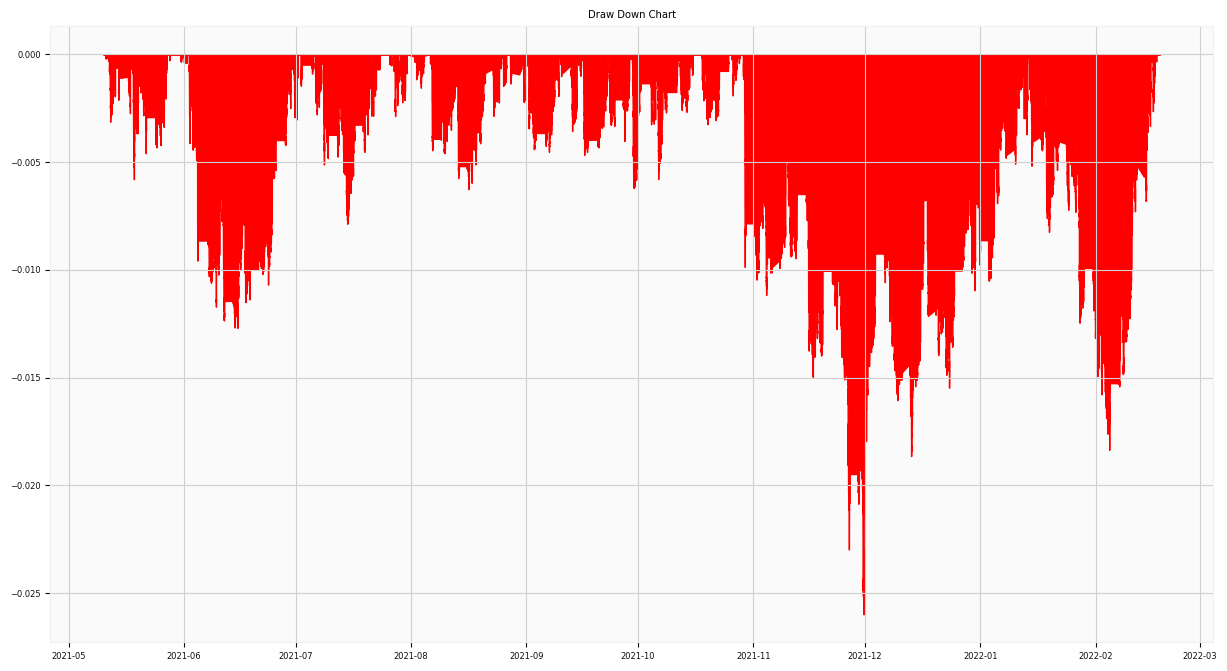

In [11]:
# DrawDown
cum = smry_df['return'].dropna().cumsum() + 1
running_max = np.maximum.accumulate(cum)
drawdown = (cum / running_max) - 1
fig,ax = plt.subplots(1, 1, sharex=True, figsize=(15, 8))
ax.fill_between(drawdown.index , drawdown  , color = 'red'  )
ax.set_title('Draw Down Chart')
plt.show()

#### Using Plotly Library For visualizing indicators and all signals of this strategy
* we used position indicator that in buy position is 1 and in sell position is -1

In [12]:
# Create subplots and mention plot grid size
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, subplot_titles=('OHLC', 'RSI' , 'Positions'), 
               row_width=[0.1,0.1 , 0.8])

# Plot OHLC on 1st row
fig.add_trace(go.Candlestick(x=smry_df.index, open=smry_df["open"], high=smry_df["high"],low=smry_df["low"], close=smry_df["close"], name="OHLC"), 
                row=1, col=1
)
# Plot lower band on 1st row
fig.add_trace(go.Scatter(x=smry_df.index, y = smry_df["l_band"] , line=dict(color='blue', width=1,  dash='dot')  ) ,
                row=1, col=1 
)
# Plot higher band on 1st row
fig.add_trace(go.Scatter(x=smry_df.index, y = smry_df["h_band"] , line=dict(color='blue', width=1,  dash='dot')  ) ,
                row=1, col=1 
)
# Plot middle band on 1st row
fig.add_trace(go.Scatter(x=smry_df.index, y = smry_df["m_band"] , line=dict(color='black', width=1,  dash='dot')  ) ,
                row=1, col=1 
)


# Plot RSI indicator on 2nd row 
fig.add_trace(go.Scatter(x=smry_df.index, y=smry_df['rsi']), row=2, col=1)

# Plot results of the strategy on 2nd row 
fig.add_trace(go.Scatter(x=smry_df.index, y=smry_df['position']), row=3, col=1)

# Do not show OHLC's rangeslider plot 
fig.update(layout_xaxis_rangeslider_visible=False)

fig.show()